# Assignment 4

## SMS Spam Classification

### Importing required libraries

In [85]:
import pandas as pd
import numpy as np
import nltk
import csv
import re 

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [119]:
import os
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from keras import utils
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

### Importing and preprocessing the dataset

In [87]:
data = pd.read_csv('/content/spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [88]:
data['v2'][4]

"Nah I don't think he goes to usf, he lives around here though"

In [89]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [90]:
data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
data.columns


Index(['v1', 'v2'], dtype='object')

In [91]:
data.shape

(5572, 2)

In [92]:
data.describe()

,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [93]:
data.isna().sum()

v1    0
v2    0
dtype: int64

In [94]:
data.duplicated().sum()

403

In [95]:
data=data.drop_duplicates()

In [96]:
data.duplicated().sum()

0

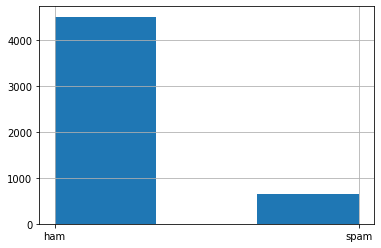

In [97]:
data['v1'].hist(bins=3)

In [101]:
data['alpha_text'] = data['v2'].apply(lambda x: re.sub(r'[^a-zA-Z ]+', '', x.lower()))
data.head()  #Removing special characters


,v1,v2,alpha_text
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [102]:
nltk.download('stopwords')
data['imp_text'] = data['alpha_text'].apply(lambda x : ' '.join([word for word in x.split() if not word in set(stopwords.words('english'))]))
data.head()  #Removing stop words


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,v1,v2,alpha_text,imp_text
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah dont think goes usf lives around though


In [106]:
# Convert text into numbers(vector)

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

In [107]:
x = cv.fit_transform(data).toarray()
x

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of ham and spam messages')

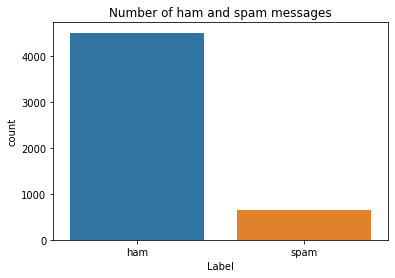

In [113]:
sns.countplot(data.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [114]:
X = data.v2
Y = data.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [117]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify=Y)

In [120]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = utils.pad_sequences(sequences,maxlen=max_len)

In [121]:
sequences_matrix.shape

(4393, 150)

In [122]:
sequences_matrix.ndim

2

In [135]:
sequences_matrix = np.reshape(sequences_matrix,(4393,150,1))

In [136]:
sequences_matrix.ndim

3

In [148]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Creating the model

In [145]:
model = Sequential()
model.add(Embedding(max_words,50,input_length=max_len))

### Adding the layers

In [146]:
model.add(LSTM(units=64,input_shape = (sequences_matrix.shape[1],1),return_sequences=True))
model.add(LSTM(units=64,return_sequences=True))
model.add(LSTM(units=64,return_sequences=True))
model.add(LSTM(units=64))
model.add(Dense(units = 256,activation = 'relu'))
model.add(Dense(units = 1,activation = 'sigmoid'))

In [150]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_6 (LSTM)               (None, 150, 64)           29440     
                                                                 
 lstm_7 (LSTM)               (None, 150, 64)           33024     
                                                                 
 lstm_8 (LSTM)               (None, 150, 64)           33024     
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_9 (Dense)             (None, 256)               16640     
                                                                 
 dense_10 (Dense)            (None, 1)                

### Compiling the model

In [151]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Fitting the model

In [152]:
M = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=5,validation_split=0.2)

Epoch 1/5
28/28 [==============================] - 41s 1s/step - loss: 0.4496 - accuracy: 0.8688 - val_loss: 0.3697 - val_accuracy: 0.8760
Epoch 2/5
28/28 [==============================] - 32s 1s/step - loss: 0.2786 - accuracy: 0.9044 - val_loss: 0.1278 - val_accuracy: 0.9636
Epoch 3/5
28/28 [==============================] - 35s 1s/step - loss: 0.0785 - accuracy: 0.9778 - val_loss: 0.0804 - val_accuracy: 0.9761
Epoch 4/5
28/28 [==============================] - 36s 1s/step - loss: 0.0529 - accuracy: 0.9858 - val_loss: 0.0689 - val_accuracy: 0.9784
Epoch 5/5
28/28 [==============================] - 30s 1s/step - loss: 0.0371 - accuracy: 0.9903 - val_loss: 0.0789 - val_accuracy: 0.9750


### Saving the model

In [153]:
model.save('spam-classifier.h5')

### Testing the model

In [157]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = utils.pad_sequences(test_sequences,maxlen=max_len)

In [158]:
accr = model.evaluate(test_sequences_matrix,Y_test)

25/25 [==============================] - 5s 85ms/step - loss: 0.0922 - accuracy: 0.9768


In [159]:
print("Accuracy of the model on Testing Data is - " , accr[1]*100 , "%")

Accuracy of the model on Testing Data is -  97.68041372299194 %


In [160]:
l = accr[0]
a =accr[1]
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(l,a))

Test set
  Loss: 0.092
  Accuracy: 0.977
